<a href="https://colab.research.google.com/github/zosimanoz/HyperspectralUnmixing/blob/main/CAEHyperspectral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/datasets")

In [3]:
!pip install spectral
!pip install pyopengl
!pip install -q pyyaml h5py
!pip install imageio
!pip install keract
from tensorflow.keras.optimizers import Adam, RMSprop
import time
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import Conv2D, Conv1D
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Dropout, MaxPooling1D
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.model_selection import train_test_split
import sklearn as sk
import spectral
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction import image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
np.random.seed(42)
import tensorflow as tf
# tf.random.set_seed(4230)
tf.random.set_seed(5242)
tf.executing_eagerly()


     |████████████████████████████████| 215kB 5.7MB/s 


True

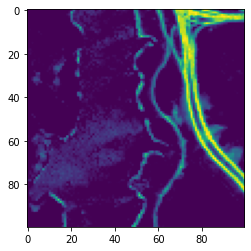

(4, 10000)

In [4]:
import spectral.io.envi as envi

hsiDataObj = envi.open(os.path.join(os.getcwd(),'jasperRidge2_R198.hdr'))

wavelengths = hsiDataObj.metadata['wavelength']
metadata = hsiDataObj.metadata
data = hsiDataObj.load()

# data = np.where(data < 0, 0, data)

data_n = np.moveaxis(data, 2, 0)

a = np.array(wavelengths)
wavelengths_numeric = [float(i) for i in wavelengths]

# Read and interpret ground truth files
gtFile = sio.loadmat(os.path.join(os.getcwd(),'end4'))
gtAbundances = gtFile['A']
gtEndmembers = gtFile['M']


abundanceData = gtAbundances.reshape([-1, 100, 100])
a = np.moveaxis(abundanceData, 0, 2)
a = np.moveaxis(a, 1, 0)

plt.imshow(a[:, :, 3])
plt.show()

gtAbundances.shape

In [5]:
train_dt = np.moveaxis(data, 2, 0)

train_dt = train_dt.reshape((train_dt.shape[0], 100, 100, 1))
train_dt.shape

(198, 100, 100, 1)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 8)         0   

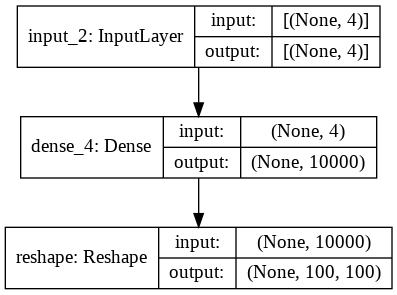

In [6]:
from keras.regularizers import l2
from keras.constraints import maxnorm, nonneg
from keras.utils.vis_utils import plot_model

latentDim = 4
encoder_inputs = Input(shape=(100, 100, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_inputs)
# x = LeakyReLU(alpha=0.3)(x)
# x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D(pool_size=(2,2))(x)


x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = LeakyReLU(alpha=0.3)(x)
# x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = LeakyReLU(alpha=0.3)(x)
# x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D(pool_size=(2,2))(x)

volume_size = K.int_shape(x)

x = Flatten()(x)

# The fully connected layer acts as our latent space representation
x = Dense(36, activation='relu')(x)
x = Dense(24, activation='relu')(x)
x = Dense(12, activation='relu')(x)
x = Dropout(rate=0.01)(x)
latent = Dense(latentDim, activation='relu')(x)

# build encoder model
encoder = Model(encoder_inputs, latent, name="encoder")
encoder.summary()


latent_inputs = Input(shape=(latentDim,))
x = Dense(10000, kernel_regularizer=l2(0.0001), kernel_constraint=nonneg())(latent_inputs)
outputs = Activation('linear')(x)
outputs = Reshape((100,100))(x)


# build the decoder model
decoder = Model(latent_inputs, outputs, name="decoder")
decoder.summary()

# build autoencoder
autoencoder = Model(encoder_inputs, decoder(encoder(encoder_inputs)), name="autoencoder")
autoencoder.summary()

optimizer = RMSprop(lr=0.0001)
autoencoder.compile(loss='mean_squared_error', optimizer=optimizer, run_eagerly=True)

plot_model(encoder, to_file='model_encoder1.png', show_shapes=True, show_layer_names=True)
plot_model(decoder, to_file='model_decoder1.png', show_shapes=True, show_layer_names=True)

In [7]:
history = autoencoder.fit(x=train_dt, y=train_dt, batch_size=32, epochs=500)

autoencoder.save('AEModelFinal_new.h5')

Epoch 1/500
7/7 [==============================] - 2s 241ms/step - loss: 0.0263
Epoch 2/500
7/7 [==============================] - 2s 230ms/step - loss: 0.0254
Epoch 3/500
7/7 [==============================] - 2s 234ms/step - loss: 0.0244
Epoch 4/500
7/7 [==============================] - 2s 229ms/step - loss: 0.0243
Epoch 5/500
7/7 [==============================] - 2s 229ms/step - loss: 0.0237
Epoch 6/500
7/7 [==============================] - 2s 229ms/step - loss: 0.0241
Epoch 7/500
7/7 [==============================] - 2s 247ms/step - loss: 0.0229
Epoch 8/500
7/7 [==============================] - 2s 236ms/step - loss: 0.0231
Epoch 9/500
7/7 [==============================] - 2s 232ms/step - loss: 0.0213
Epoch 10/500
7/7 [==============================] - 2s 215ms/step - loss: 0.0194
Epoch 11/500
7/7 [==============================] - 2s 222ms/step - loss: 0.0186
Epoch 12/500
7/7 [==============================] - 2s 239ms/step - loss: 0.0179
Epoch 13/500
7/7 [===================

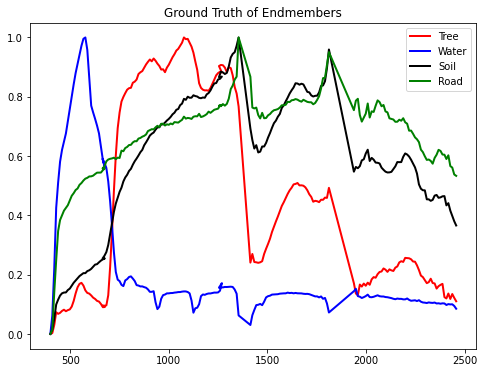

In [54]:

treeEndmember = gtEndmembers[:,0]
waterEndmember = gtEndmembers[:, 1]
landEndmember = gtEndmembers[:,2]
roadEndmember = gtEndmembers[:,3]


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


mysignals = [{'name': 'Tree', 'x': wavelengths_numeric,
             'y': treeEndmember, 'color':'r', 'linewidth':2},
            {'name': 'Water', 'x': wavelengths_numeric,
             'y': waterEndmember, 'color':'b', 'linewidth':2},
            {'name': 'Soil', 'x': wavelengths_numeric,
             'y': landEndmember, 'color':'k', 'linewidth':2},
            {'name': 'Road', 'x': wavelengths_numeric,
             'y': roadEndmember, 'color':'g', 'linewidth':2}]


fig, ax = plt.subplots(figsize=(8,6))
for signal in mysignals:
    ax.plot(signal['x'], signal['y'], 
            color=signal['color'], 
            linewidth=signal['linewidth'],
            label=signal['name'])

# Enable legend
ax.legend()
ax.set_title("Ground Truth of Endmembers")
plt.show()

In [9]:
from tensorflow.keras import backend as K
from keract import get_activations
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# x_train = np.reshape(train_dt, (len(train_dt), 100, 100, 1)) 
# print(x_train.shape)
activations = get_activations(encoder, train_dt, layer_names=None, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
encoderActivationsOrg = activations.get('dense_2')

abundanceMatrix = autoencoder.layers[2].get_weights()
abundanceMatrixData = abundanceMatrix[0]
extractedAbundances = abundanceMatrixData.reshape(-1, 100, 100)
extractedAbundanceMaps = np.moveaxis(extractedAbundances, 0, 2)
extractedAbundanceMaps.shape


(100, 100, 4)

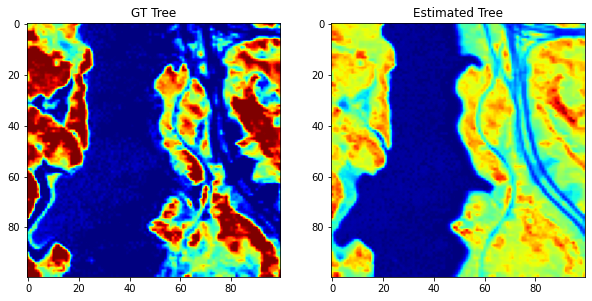

In [10]:

plt.figure(figsize=(10,10))
plt.axis('off')
plt.subplot(121)
plt.gca().set_title('GT Tree')
plt.imshow(a[:,:,0], cmap='jet')

plt.subplot(122)
plt.gca().set_title('Estimated Tree')
plt.imshow(extractedAbundanceMaps[:,:,3], cmap='jet')
plt.show()



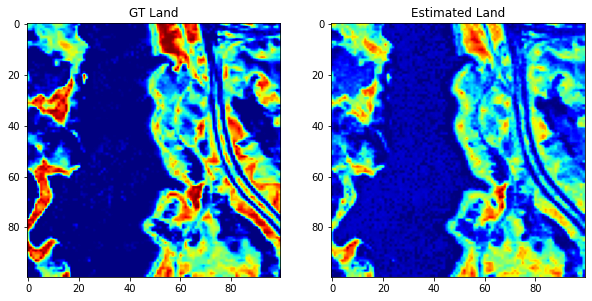

In [11]:

plt.figure(figsize=(10,10))
plt.axis('off')
plt.subplot(121)
plt.gca().set_title('GT Land')
plt.imshow(a[:,:,2], cmap='jet')

plt.subplot(122)
plt.gca().set_title('Estimated Land')
plt.imshow(extractedAbundanceMaps[:,:,1], cmap='jet')
plt.show()

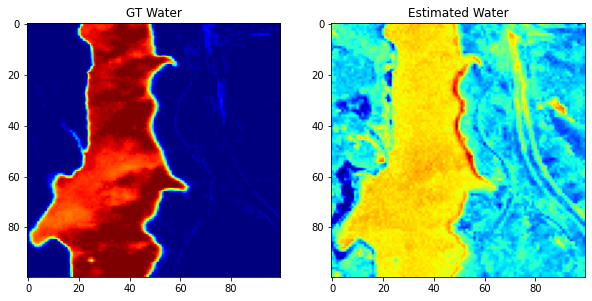

In [12]:

plt.figure(figsize=(10,10))
plt.axis('off')
plt.subplot(121)
plt.gca().set_title('GT Water')
plt.imshow(a[:,:,1], cmap='jet')

plt.subplot(122)
plt.gca().set_title('Estimated Water')
plt.imshow(extractedAbundanceMaps[:,:,2], cmap='jet')
plt.show()

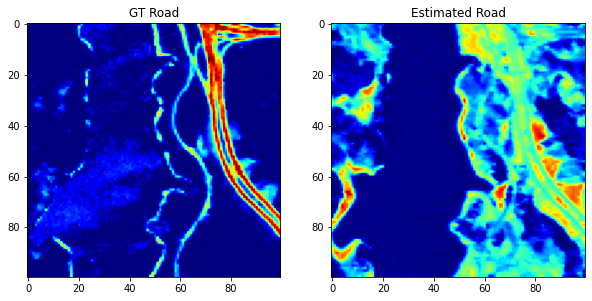

In [13]:

plt.figure(figsize=(10,10))
plt.axis('off')
plt.subplot(121)
plt.gca().set_title('GT Road')
plt.imshow(a[:,:,3], cmap='jet')

plt.subplot(122)
plt.gca().set_title('Estimated Road')
plt.imshow(extractedAbundanceMaps[:,:,0], cmap='jet')
plt.show()

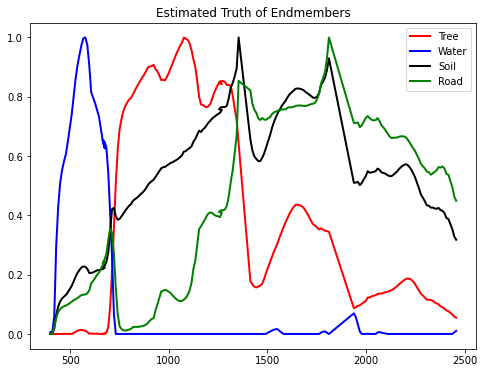

In [53]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler

endmembers = encoder.predict(train_dt)

scaler = MinMaxScaler()
scaledEndmembers = scaler.fit_transform(endmembers) 
# new ones
pWaterEndmember = scaledEndmembers[:,2]
pTreeEndmember = scaledEndmembers[:, 3]
pLandEndmember = scaledEndmembers[:,1]
pRoadEndmember = scaledEndmembers[:,0]


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


mysignals = [{'name': 'Tree', 'x': wavelengths_numeric,
             'y': pTreeEndmember, 'color':'r', 'linewidth':2},
            {'name': 'Water', 'x': wavelengths_numeric,
             'y': pWaterEndmember, 'color':'b', 'linewidth':2},
            {'name': 'Soil', 'x': wavelengths_numeric,
             'y': pLandEndmember, 'color':'k', 'linewidth':2},
            {'name': 'Road', 'x': wavelengths_numeric,
             'y': pRoadEndmember, 'color':'g', 'linewidth':2}]


# red -> tree
# green -> road
# black -> water
# blue -> soil

fig, ax = plt.subplots(figsize=(8,6))
for signal in mysignals:
    ax.plot(signal['x'], signal['y'], 
            color=signal['color'], 
            linewidth=signal['linewidth'],
            label=signal['name'])

# Enable legend
ax.legend()
ax.set_title("Estimated Truth of Endmembers")
plt.show()

In [30]:
# Extracted

abundanceTree = extractedAbundanceMaps[: , :, 3]
abundanceLand = extractedAbundanceMaps[: , :, 1]
abundanceWater = extractedAbundanceMaps[: , :, 2]
abundanceRoad = extractedAbundanceMaps[: , :, 0]

# Ground Truth
gtAbundanceData = np.moveaxis(abundanceData, 0, 2)

gtAbundanceTree = gtAbundanceData[: , :, 0]
gtAbundanceLand = gtAbundanceData[: , :, 2]
gtAbundanceWater = gtAbundanceData[: , :, 1]
gtAbundanceRoad = gtAbundanceData[: , :, 3]

# Extracted endmembers
predWaterEndmember = scaledEndmembers[:,2]
predTreeEndmember = scaledEndmembers[:, 3]
predLandEndmember = scaledEndmembers[:,1]
predRoadEndmember = scaledEndmembers[:,0]


from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
gtEndmembers = scaler.fit_transform(gtEndmembers)

# Ground Truth endmembers
gtTreeEndmember = gtEndmembers[:,0]
gtWaterEndmember = gtEndmembers[:, 1]
gtLandEndmember = gtEndmembers[:,2]
gtRoadEndmember = gtEndmembers[:,3]


In [31]:
# SSIM of GT and Reconstructed Images

from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

def compare_images(gtImg, reconImg, gt_title, recon_title, title):
  ssim_measure = ssim(gtImg, reconImg, win_size=11)

  fig = plt.figure(title, figsize=(8,8))
  plt.suptitle(f"SSIM {ssim_measure}", y = 0.77)

  a = fig.add_subplot(1, 2, 1)
  plt.imshow(gtImg, cmap=plt.cm.jet)
  plt.title(gt_title)

  a = fig.add_subplot(1, 2, 2)
  plt.imshow(reconImg, cmap=plt.cm.jet)
  plt.title(recon_title)

  plt.show()


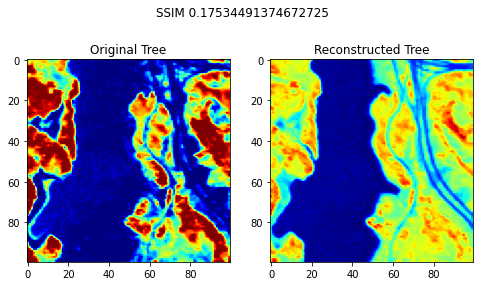

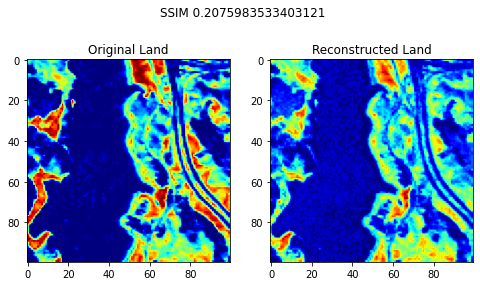

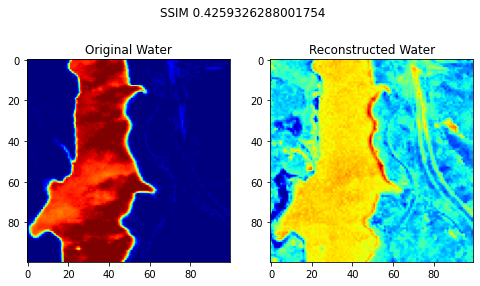

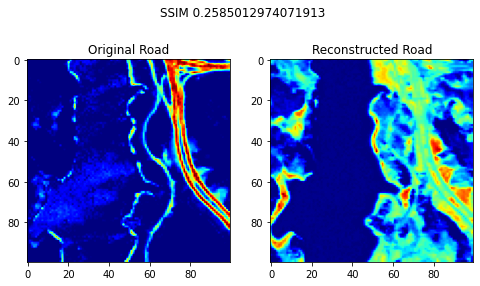

In [32]:

gtImgTree = gtAbundanceTree   
reconImgTree = abundanceTree  
gtImgTree = np.array(gtImgTree, dtype=np.float32)
gtImgTree = np.moveaxis(gtImgTree, 1, 0)

gtImgSoil = gtAbundanceLand   
reconImgSoil = abundanceLand  
gtImgSoil = np.array(gtImgSoil, dtype=np.float32)
gtImgSoil = np.moveaxis(gtImgSoil, 1, 0)

gtImgWater = gtAbundanceWater 
reconImgWater = abundanceWater  
gtImgWater = np.array(gtImgWater, dtype=np.float32)
gtImgWater = np.moveaxis(gtImgWater, 1, 0)

gtImgRoad = gtAbundanceRoad  
reconImgRoad = abundanceRoad  
gtImgRoad = np.array(gtImgRoad, dtype=np.float32)
gtImgRoad = np.moveaxis(gtImgRoad, 1, 0)


compare_images(gtImgTree, reconImgTree, gt_title="Original Tree", recon_title="Reconstructed Tree", title="Original Vs Reconstructed")
compare_images(gtImgSoil, reconImgSoil, gt_title="Original Land", recon_title="Reconstructed Land", title="Original Vs Reconstructed")
compare_images(gtImgWater, reconImgWater, gt_title="Original Water", recon_title="Reconstructed Water", title="Original Vs Reconstructed")
compare_images(gtImgRoad, reconImgRoad, gt_title="Original Road", recon_title="Reconstructed Road", title="Original Vs Reconstructed")


In [33]:
def RMSE(s1, s2):
    try:
        squared_difference = (s1 - s2)**2
        mean_squared_difference = squared_difference.mean()
    except ValueError:
        return 0.0
    return np.sqrt(mean_squared_difference)

In [34]:
rmse_tree = RMSE(reconImgTree, gtImgTree)
rmse_soil = RMSE(reconImgSoil, gtImgSoil)
rmse_water = RMSE(reconImgWater, gtImgWater)
rmse_road = RMSE(reconImgRoad, gtImgRoad)

print(f"RMSE:: \nTree: {rmse_tree}, \nSoil: {rmse_soil},  \nWater: {rmse_water}, \nRoad: {rmse_road}")

RMSE:: 
Tree: 0.5019148588180542, 
Soil: 0.3820837438106537,  
Water: 0.5332382321357727, 
Road: 0.2259415090084076


In [48]:
def mse(recon, gt):
  err = np.sum((gt.astype('float') - recon.astype('float')) ** 2)
  err /= float(gt.shape[0] * recon.shape[1])
  return err

In [52]:
mse_tree = mse(reconImgTree, gtImgTree)
mse_soil = mse(reconImgSoil, gtImgSoil)
mse_water = mse(reconImgWater, gtImgWater)
mse_road = mse(reconImgRoad, gtImgRoad)


print(f"MSE:: \nTree: {mse_tree}, \nSoil: {mse_soil},  \nWater: {mse_water}, \nRoad: {mse_road}")

MSE:: 
Tree: 0.25191855078622305, 
Soil: 0.14598798337598617,  
Water: 0.2843430185688095, 
Road: 0.0510495684293165


In [35]:
import numpy as np
import math
# def loss function
def SAD(s1, s2):
  try:
    s1_norm = math.sqrt(np.dot(s1, s1))
    s2_norm = math.sqrt(np.dot(s2, s2))
    sum_s1_s2 = np.dot(s1, s2)
    angle = math.acos(sum_s1_s2 / (s1_norm * s2_norm))
  except ValueError:
    return 0.0
  return angle 

In [36]:
sad_tree = SAD(predTreeEndmember, gtTreeEndmember)
sad_soil = SAD(predLandEndmember, gtLandEndmember)
sad_water = SAD(predWaterEndmember, gtWaterEndmember)
sad_road = SAD(predRoadEndmember, gtRoadEndmember)

print(f"SAD:: \nTree: {sad_tree}, \nSoil: {sad_soil},  \nWater: {sad_water}, \nRoad: {sad_road}")

mSAD = (sad_road + sad_tree + sad_soil + sad_water) / 4

SAD:: 
Tree: 0.11475781214327727, 
Soil: 0.09252413436534314,  
Water: 0.3938796508312299, 
Road: 0.4835232995904296


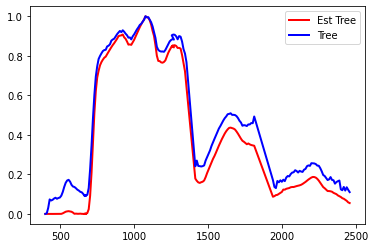

In [37]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


mysignalsTree = [{'name': 'Est Tree', 'x': wavelengths_numeric,
             'y': predTreeEndmember, 'color':'r', 'linewidth':2},
            {'name': 'Tree', 'x': wavelengths_numeric,
             'y': gtTreeEndmember, 'color':'b', 'linewidth':2},
            ]

fig, ax = plt.subplots()
for signal in mysignalsTree:
    ax.plot(signal['x'], signal['y'], 
            color=signal['color'], 
            linewidth=signal['linewidth'],
            label=signal['name'])

ax.legend()
plt.show()

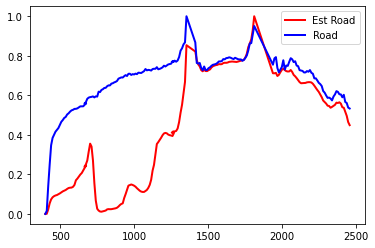

In [38]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


mysignalsRoad = [{'name': 'Est Road', 'x': wavelengths_numeric,
             'y': predRoadEndmember, 'color':'r', 'linewidth':2},
            {'name': 'Road', 'x': wavelengths_numeric,
             'y': gtRoadEndmember, 'color':'b', 'linewidth':2},
            ]


fig, ax = plt.subplots()
for signal in mysignalsRoad:
    ax.plot(signal['x'], signal['y'], 
            color=signal['color'], 
            linewidth=signal['linewidth'],
            label=signal['name'])
    

ax.legend()
plt.show()

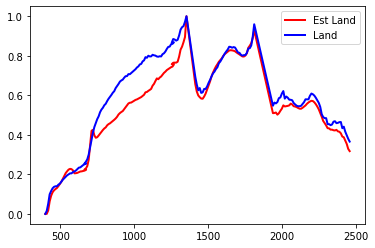

In [39]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mysignalsLand = [{'name': 'Est Land', 'x': wavelengths_numeric,
             'y': predLandEndmember, 'color':'r', 'linewidth':2},
            {'name': 'Land', 'x': wavelengths_numeric,
             'y': gtLandEndmember, 'color':'b', 'linewidth':2},
            ]

fig, ax = plt.subplots()   
for signal in mysignalsLand:
    ax.plot(signal['x'], signal['y'], 
            color=signal['color'], 
            linewidth=signal['linewidth'],
            label=signal['name'])


ax.legend()
plt.show()

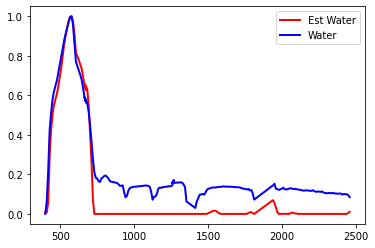

In [40]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mysignalsWater = [{'name': 'Est Water', 'x': wavelengths_numeric,
             'y': predWaterEndmember, 'color':'r', 'linewidth':2},
            {'name': 'Water', 'x': wavelengths_numeric,
             'y': gtWaterEndmember, 'color':'b', 'linewidth':2},
            ]

fig, ax = plt.subplots()
for signal in mysignalsWater:
    ax.plot(signal['x'], signal['y'], 
            color=signal['color'], 
            linewidth=signal['linewidth'],
            label=signal['name'])

ax.legend()
plt.show()

In [101]:
from keras.models import Model
layer_name = 'conv2d'
intermediate_layer_model = Model(inputs=encoder.input,
                                          outputs=encoder.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(train_dt)

intermediate_output.shape

(198, 100, 100, 16)

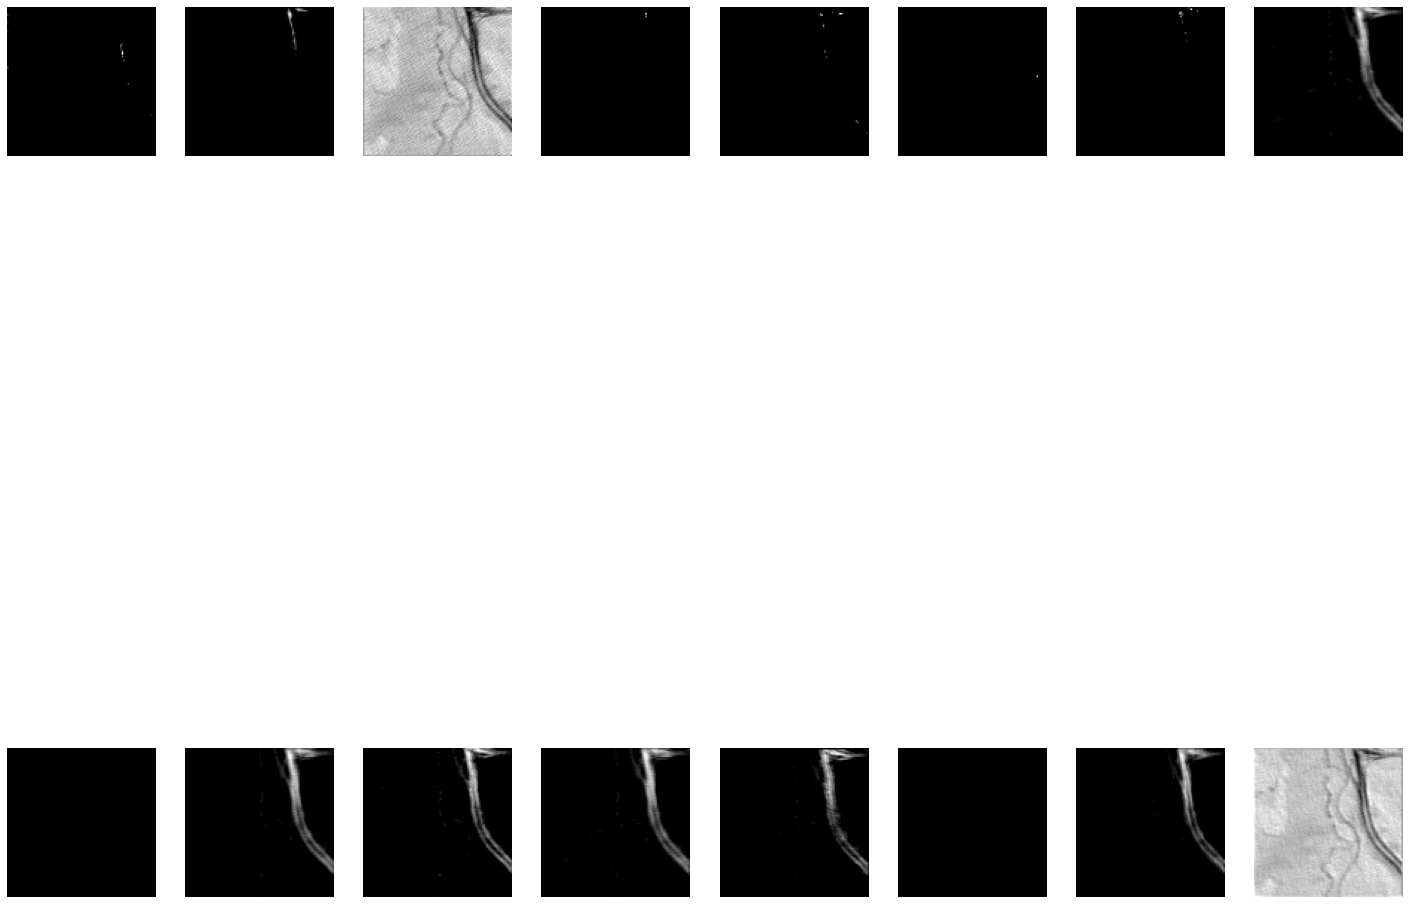

In [102]:
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline

test_input_img = intermediate_output[0]
# plt.imshow(test_input_img[:,:,10],cmap='gray') 

fig=plt.figure(figsize=(25, 25))
columns = 8
rows = 2
for i in range(1, 17):
    fig.add_subplot(rows, columns, i)
    plt.imshow(test_input_img[:,:, i-1], cmap="gray")
    plt.axis('off')
plt.show()